# 循环神经网络的简洁实现
:label:`sec_rnn-concise`

虽然 :numref:`sec_rnn_scratch`
对了解循环神经网络的实现方式具有指导意义，但并不方便。
本节将展示如何使用深度学习框架的高级API提供的函数更有效地实现相同的语言模型。
我们仍然从读取时光机器数据集开始。


In [1]:
from mxnet import np, npx
from mxnet.gluon import nn, rnn
from d2l import mxnet as d2l

npx.set_np()

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**定义模型**]

高级API提供了循环神经网络的实现。
我们构造一个具有256个隐藏单元的单隐藏层的循环神经网络层`rnn_layer`。
事实上，我们还没有讨论多层循环神经网络的意义（这将在 :numref:`sec_deep_rnn`中介绍）。
现在，你仅需要将多层理解为一层循环神经网络的输出被用作下一层循环神经网络的输入就足够了。


In [2]:
num_hiddens = 256
rnn_layer = rnn.RNN(num_hiddens)
rnn_layer.initialize()

初始化隐状态是简单的，只需要调用成员函数`begin_state`即可。
函数将返回一个列表（`state`），列表中包含了初始隐状态用于小批量数据中的每个样本，
其形状为（隐藏层数，批量大小，隐藏单元数）。
对于以后要介绍的一些模型（例如长-短期记忆网络），这样的列表还会包含其他信息。


In [3]:
state = rnn_layer.begin_state(batch_size=batch_size)
len(state), state[0].shape

(1, (1, 32, 256))

[**通过一个隐状态和一个输入，我们就可以用更新后的隐状态计算输出。**]
需要强调的是，`rnn_layer`的“输出”（`Y`）不涉及输出层的计算：
它是指每个时间步的隐状态，这些隐状态可以用作后续输出层的输入。


此外，`rnn_layer`返回的更新后的隐状态（`state_new`）
是指小批量数据的最后时间步的隐状态。
这个隐状态可以用来初始化顺序分区中一个迭代周期内下一个小批量数据的隐状态。
对于多个隐藏层，每一层的隐状态将存储在（`state_new`）变量中。
至于稍后要介绍的某些模型（例如，长－短期记忆），此变量还包含其他信息。


In [4]:
X = np.random.uniform(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

((35, 32, 256), 1, (1, 32, 256))

与 :numref:`sec_rnn_scratch`类似，
[**我们为一个完整的循环神经网络模型定义了一个`RNNModel`类**]。
注意，`rnn_layer`只包含隐藏的循环层，我们还需要创建一个单独的输出层。


In [5]:
#@save
class RNNModel(nn.Block):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = nn.Dense(vocab_size)

    def forward(self, inputs, state):
        X = npx.one_hot(inputs.T, self.vocab_size)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)
        output = self.dense(Y.reshape(-1, Y.shape[-1]))
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)

## 训练与预测

在训练模型之前，让我们[**基于一个具有随机权重的模型进行预测**]。


In [6]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, len(vocab))
net.initialize(force_reinit=True, ctx=device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellervmoopwrrrr'

很明显，这种模型根本不能输出好的结果。
接下来，我们使用 :numref:`sec_rnn_scratch`中
定义的超参数调用`train_ch8`，并且[**使用高级API训练模型**]。


perplexity 1.2, 148888.0 tokens/sec on gpu(0)
time traveller held in his hand was a glitteringmetallic framewo


travelleryou can show black andeed and animated thefire bur


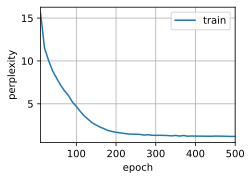

In [7]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

与上一节相比，由于深度学习框架的高级API对代码进行了更多的优化，
该模型在较短的时间内达到了较低的困惑度。

## 小结

* 深度学习框架的高级API提供了循环神经网络层的实现。
* 高级API的循环神经网络层返回一个输出和一个更新后的隐状态，我们还需要计算整个模型的输出层。
* 相比从零开始实现的循环神经网络，使用高级API实现可以加速训练。

## 练习

1. 尝试使用高级API，你能使循环神经网络模型过拟合吗？
1. 如果在循环神经网络模型中增加隐藏层的数量会发生什么？你能使模型正常工作吗？
1. 尝试使用循环神经网络实现 :numref:`sec_sequence`的自回归模型。


[Discussions](https://discuss.d2l.ai/t/2105)
